In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
import sys
import warnings
import matplotlib.pyplot as plt
import random
warnings.filterwarnings('ignore')

In [10]:
pwd

'/Users/trentonbricken/AnonPaper1/FlyModel'

In [2]:
def split_data(data, labels, split):
    from collections import Counter
    distinct_labels = list(Counter(labels).keys())
    n_labels = len(distinct_labels)
    n_split = int(n_labels/split)
    trans = data.T
    trans.columns = labels
    datasets = {}
    datalabels = {}
    for i in range(n_split):
        cond1 = trans.columns.values >= i*split
        cond2 = trans.columns.values < (i+1)*split
        out = trans.iloc[:,cond1&cond2]
        out_label = out.columns.values
        datasets[i] = out.T
        datalabels[i] = out_label
    return (datasets, datalabels)

In [3]:
def generate_transformation_matrix(n_kc,n_orn,n_response,seed):
    R = np.zeros((n_kc, n_orn))
    for i in range(n_kc):
        random.seed(seed+i)
        np.random.seed(seed+i)
        R[i,random.sample(list(range(n_orn)), n_response)] = 1
    return R

def get_KC(p,R,thresh):
    '''
    odor: a vector of ORN responses for a given odor
    w: inhibitory synaptic strength from LN to PN
    R: random linear transformation matrix from PN to KC
    thresh: rectlinear threshold for KC activation
    '''
    KC = np.matmul(R,p)
    KC[KC<=thresh] = 0
    threshold = np.quantile(KC,0.99) # this is the topK operation. keeps 1% active. 
    KC[KC<threshold] = 0
    KC = KC/np.max(KC) # renorm of the KC values here. 
    #KC[KC>0] = 1
    return KC

In [4]:
def train(data, label, lr, n_class, shift):
    from collections import Counter
    weights = np.zeros([n_class,n_kc])#*10.0
    kcs = np.array([get_KC(np.array(data.iloc[i,:]),R,thresh) for i in range(data.shape[0])])
    distinct_label = np.sort(list(Counter(label).keys()))
    if len(distinct_label) != n_class:
        raise ValueError('Number of classes to be trained does not match!!!')
    for i in range(n_class):
        sum_kc = np.sum(kcs[np.array(label==distinct_label[i])],axis=0)
        weights[distinct_label[i]-shift] += lr*sum_kc
        #weights[weights<0] = 0
        weights[weights>1] = 1
    return weights

In [5]:
def accu(weights, data, label):
    kcs = [get_KC(np.array(data.iloc[i,:]),R,thresh) for i in range(data.shape[0])]
    kcs = np.array(kcs)
    result = np.matmul(weights, kcs.T)
    pred = np.argmax(result, axis=0)
    return np.sum(pred==label)/len(label)

train_data = pd.read_csv('./processed_data/cifar100_train_resnet18.csv',header=None)
train_label = pd.read_csv('./processed_data/cifar100_train_label_resnet18.csv',header=None)
train_label = [train_label.values[i][0] for i in range(train_label.shape[0])]
test = pd.read_csv('./processed_data/cifar100_test_resnet18.csv',header=None)
test_label = pd.read_csv('./processed_data/cifar100_test_label_resnet18.csv',header=None)
test_label = [test_label.values[i][0] for i in range(test_label.shape[0])]

train_data = pd.DataFrame(minmax_scale(train_data,axis=1))
test = pd.DataFrame(minmax_scale(test,axis=1))

train_datasets, train_labels = split_data(train_data, train_label, 4)
test_datasets, test_labels = split_data(test, test_label, 4)

In [17]:
import torch

def load_my_dataset(seed_ind, min_max_scale=True):
    
    train_datasets = dict()
    train_labels = dict()

    test_datasets = dict()
    test_labels = dict()
    
    seed_ind_map = {1:3, 2:15, 3:27 , 4:97}
    
    if seed_ind==0:
        file_suffix = ""
    else: 
        file_suffix = f"_RandSeed_{seed_ind_map[seed_ind]}"

    for train_o_test in ['train', 'test']:

        if train_o_test == 'train':
            ddict, ldict = train_datasets, train_labels
        else: 
            ddict, ldict = test_datasets, test_labels

        for ind in range(n_task):
            fname = f"data/{dataset_path}{file_suffix}/split_{train_o_test}_{ind}.pt"
            d, l = torch.load(fname)
            
            if "MNIST" in dataset_name:
                d = d.type(torch.float)
                d = d.flatten(start_dim=1)
                

            if d.dtype is torch.uint8:
                # more efficient form of storage
                d = d.type(torch.float)/255

            d,l= d.numpy(), l.numpy()
            if min_max_scale:
                d = minmax_scale(d,axis=1)
            ddict[ind] = pd.DataFrame(d)
            
            unique_labels = np.sort(np.unique(l))
            # assuming there are always 2 per class here
            assert classes_per_split==2, "this code will not work otherwise."
            l1_mask = l==unique_labels[0]
            l2_mask = l==unique_labels[1]
            l[l1_mask]=(ind*2)
            l[l2_mask]=(ind*2)+1
            
            ldict[ind] = l
            
    return train_datasets, train_labels, test_datasets, test_labels


In [68]:
dataset_name = "MNIST"

n_kc = 10000 #10000 #20000
#512
n_response = 32 #32 #64 # approx 10% of the ORNs
seeds = [1,12,21,35,78]
thresh = 0
only_one_seed = False
if dataset_name=="CIFAR100":
    n_orn = 256
    n_task = 50 #25
    seeds = seeds[:3]
    dataset_path=f"ConvMixerWTransforms_ImgNet32_{dataset_name}"
elif dataset_name=="CIFAR10":
    n_orn = 256
    n_task = 5
    dataset_path=f"ConvMixerWTransforms_ImgNet32_{dataset_name}"
elif dataset_name=="MNIST":
    n_orn = 784
    n_task = 5
    dataset_path=f"{dataset_name}"
    only_one_seed = True
    seeds=[1]
elif dataset_name=="FashionMNIST":
    n_orn = 784
    n_task = 5
    dataset_path=f"{dataset_name}"
    only_one_seed = True
    seeds=[1]
else: 
    raise Exception()
lr = 0.005 # 0.01 #0.2
classes_per_split = 2

min_max_scale = True

In [69]:
for seed_ind, seed in enumerate(seeds): # seed ind is used for the dataset. 
    if only_one_seed: 
        seed_ind=0
    train_datasets, train_labels, test_datasets, test_labels = load_my_dataset(seed_ind, min_max_scale=min_max_scale)
    R = generate_transformation_matrix(n_kc,n_orn,n_response,seed)
    accuracy = np.zeros([n_task, n_task])
    trained_weights = {}
    for i in range(n_task):
        trained_weights[i] = train(train_datasets[i], train_labels[i], lr, classes_per_split, i*classes_per_split)

        weights_to_test = np.concatenate([trained_weights[j] for j in range(i+1)])

        for j in range(i+1):
            # checking forgetting for each of them. 
            accuracy[i,j] = accu(weights_to_test,test_datasets[j],test_labels[j])

        print('loop '+str(i+1)+' done! accuracy here:', np.mean(accuracy[i,:]))
        
    accuracy = pd.DataFrame(accuracy)
    accuracy.to_csv(f'./accuracy/FlyModel_{dataset_name}_convMixer_lr_{lr}_randseed_{seed}_nkc={n_kc}_nresp={n_response}_minmax={min_max_scale}.csv',index=False,header=False)
    
    final_res = [np.mean(accuracy.iloc[i,:]) for i in range(n_task)]
    print(final_res)
    print('final performance', final_res[-1])

loop 1 done! accuracy here: 0.19952718676122932
loop 2 done! accuracy here: 0.38720333979341626
loop 3 done! accuracy here: 0.5647427548605494
loop 4 done! accuracy here: 0.7433792401346604
loop 5 done! accuracy here: 0.8915778460062544
[0.19952718676122932, 0.38720333979341626, 0.5647427548605494, 0.7433792401346604, 0.8915778460062544]
final performance 0.8915778460062544


In [ ]:
# analyze the data runs: 

In [148]:
dataset_name = "CIFAR100"

n_kc = 10000#20000
#512
n_response = 32#32 #64 # approx 10% of the ORNs
seeds = [1,12,21,35,78]

if dataset_name=="CIFAR100":
    n_orn = 256
    n_task = 50 #25
    dataset_path=f"ConvMixerWTransforms_ImgNet32_{dataset_name}"
    seeds = seeds[:3]
    nsteps = 500
    
elif dataset_name=="CIFAR10":
    n_orn = 256
    n_task = 5
    nsteps = 500
    dataset_path=f"ConvMixerWTransforms_ImgNet32_{dataset_name}"
elif dataset_name=="MNIST":
    n_orn = 784
    n_task = 5
    nsteps = None
    dataset_path=f"{dataset_name}"
    seeds = [seeds[0]]
    
print("Number of seeds", len(seeds))

lr = 0.2
classes_per_split = 2

min_max_scale = True

seed_accs = np.zeros([len(seeds), n_task])
t1_accs = np.zeros([len(seeds), n_task])
for sind, seed in enumerate(seeds):
    
    accuracy = pd.read_csv(f"accuracy/FlyModel_{dataset_name}_convMixer_lr_{lr}_randseed_{seed}_nkc={n_kc}_nresp={n_response}_minmax={min_max_scale}.csv",header=None)
    final_res = [np.mean(accuracy.iloc[i,:]) for i in range(n_task)]
    t1_accs[sind] = accuracy[0]
    print(final_res)
    print('final performance', final_res[-1])
    seed_accs[sind] = final_res
print("==========")
print(seed_accs.mean(axis=0))
print(seed_accs.mean(axis=0)[-1])

Number of seeds 3
[0.0197, 0.0387, 0.0541, 0.0709, 0.08929999999999999, 0.10220000000000001, 0.11969999999999999, 0.1335, 0.149, 0.16210000000000002, 0.177, 0.1919, 0.2027, 0.2155, 0.22800000000000004, 0.23980000000000004, 0.25190000000000007, 0.2602, 0.2723, 0.28550000000000003, 0.29730000000000006, 0.3089, 0.3146999999999999, 0.3235, 0.3379, 0.3453, 0.35730000000000006, 0.3678, 0.3761, 0.3863000000000001, 0.39710000000000006, 0.40840000000000004, 0.41489999999999994, 0.4247000000000001, 0.4396000000000001, 0.4488999999999999, 0.45360000000000006, 0.4610000000000001, 0.47290000000000015, 0.48470000000000013, 0.49250000000000005, 0.5043000000000001, 0.5146, 0.5262, 0.5382000000000001, 0.5499, 0.5549000000000001, 0.5669, 0.5731, 0.5801000000000001]
final performance 0.5801000000000001
[0.0169, 0.034, 0.0535, 0.0716, 0.08800000000000001, 0.1038, 0.11919999999999999, 0.13290000000000002, 0.14859999999999998, 0.1594, 0.1722, 0.1858, 0.2006, 0.21330000000000002, 0.2195, 0.22990000000000002,

In [149]:
source = t1_accs # t1_accs #seed_accs
mu = source.mean(axis=0)
std = source.std(axis=0)

line = []
std_line = []
for n in range(n_task):
    line += [mu[n]]*nsteps
    std_line += [std[n]]*nsteps
len(line)

25000

In [150]:
mu

array([0.935     , 0.89833333, 0.88666667, 0.87333333, 0.86833333,
       0.83666667, 0.83166667, 0.815     , 0.81      , 0.78666667,
       0.76      , 0.74333333, 0.735     , 0.72666667, 0.72166667,
       0.715     , 0.71333333, 0.70833333, 0.69      , 0.67666667,
       0.67      , 0.67      , 0.66      , 0.65      , 0.64833333,
       0.64      , 0.63333333, 0.63      , 0.595     , 0.59166667,
       0.59166667, 0.58166667, 0.58      , 0.56166667, 0.56      ,
       0.56      , 0.55833333, 0.55833333, 0.55666667, 0.55166667,
       0.55166667, 0.54      , 0.54      , 0.53833333, 0.53833333,
       0.535     , 0.53      , 0.53      , 0.52666667, 0.52666667])

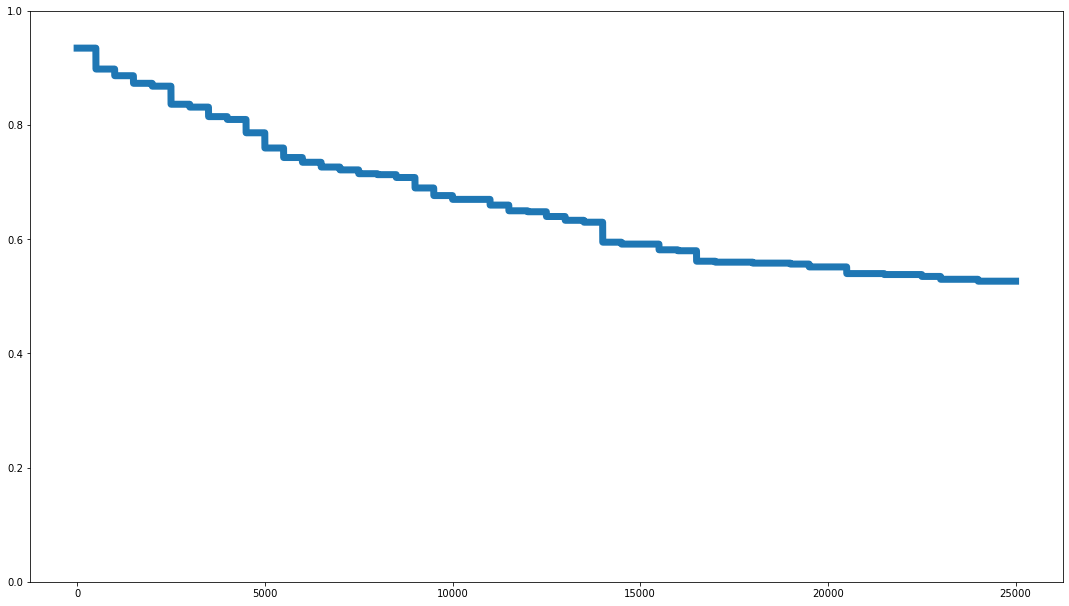

In [151]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(np.arange(nsteps*n_task), line, linewidth=7)
plt.ylim(0,1.0)
plt.show()

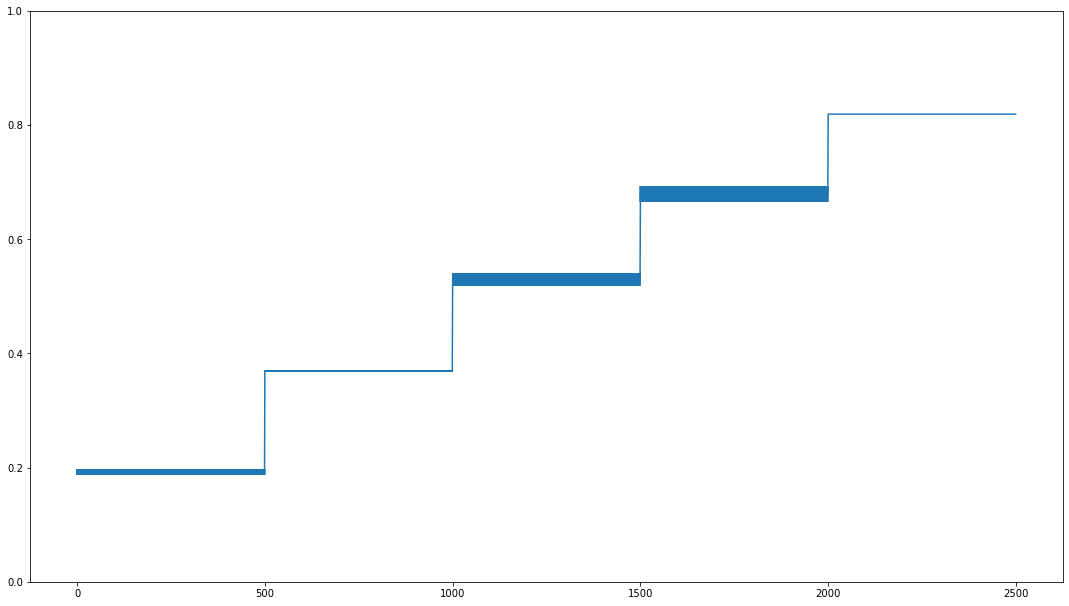

In [140]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.errorbar(np.arange(nsteps*n_task), line, yerr=std_line)
plt.ylim(0,1.0)
plt.show()

In [109]:
!ls accuracy/

FlyModel_CIFAR100_convMixer_lr_0.2_randseed_12_nkc=10000_nresp=32_minmax=True.csv
FlyModel_CIFAR100_convMixer_lr_0.2_randseed_12_nkc=1000_nresp=32_minmax=True.csv
FlyModel_CIFAR100_convMixer_lr_0.2_randseed_12_nkc=1000_nresp=3_minmax=True.csv
FlyModel_CIFAR100_convMixer_lr_0.2_randseed_1_nkc=10000_nresp=32_minmax=True.csv
FlyModel_CIFAR100_convMixer_lr_0.2_randseed_1_nkc=1000_nresp=3_minmax=True.csv
FlyModel_CIFAR100_convMixer_lr_0.2_randseed_21_nkc=10000_nresp=32_minmax=True.csv
FlyModel_CIFAR100_convMixer_lr_0.2_randseed_21_nkc=1000_nresp=32_minmax=True.csv
FlyModel_CIFAR100_convMixer_lr_0.2_randseed_21_nkc=1000_nresp=3_minmax=True.csv
FlyModel_CIFAR100_convMixer_lr_0.2_randseed_35_nkc=10000_nresp=32_minmax=True.csv
FlyModel_CIFAR100_convMixer_lr_0.2_randseed_35_nkc=1000_nresp=32_minmax=True.csv
FlyModel_CIFAR100_convMixer_lr_0.2_randseed_35_nkc=1000_nresp=3_minmax=True.csv
FlyModel_CIFAR100_convMixer_lr_0.2_randseed_78_nkc=10000_nresp=32_minmax=True.csv
FlyModel_CIFAR100_convMixer_l

In [19]:
[np.mean(df.iloc[i,:]) for i in range(n_task)]

[0.0197,
 0.0387,
 0.0541,
 0.0709,
 0.08929999999999999,
 0.10220000000000001,
 0.11969999999999999,
 0.1335,
 0.149,
 0.16210000000000002,
 0.177,
 0.1919,
 0.2027,
 0.2155,
 0.22800000000000004,
 0.23980000000000004,
 0.25190000000000007,
 0.2602,
 0.2723,
 0.28550000000000003,
 0.29730000000000006,
 0.3089,
 0.3146999999999999,
 0.3235,
 0.3379,
 0.3453,
 0.35730000000000006,
 0.3678,
 0.3761,
 0.3863000000000001,
 0.39710000000000006,
 0.40840000000000004,
 0.41489999999999994,
 0.4247000000000001,
 0.4396000000000001,
 0.4488999999999999,
 0.45360000000000006,
 0.4610000000000001,
 0.47290000000000015,
 0.48470000000000013,
 0.49250000000000005,
 0.5043000000000001,
 0.5146,
 0.5262,
 0.5382000000000001,
 0.5499,
 0.5549000000000001,
 0.5669,
 0.5731,
 0.5801000000000001]

In [20]:
[np.mean(df.iloc[i,:i+1]) for i in range(n_task)]

[0.985,
 0.9675,
 0.9016666666666667,
 0.88625,
 0.893,
 0.8516666666666667,
 0.8549999999999999,
 0.8343750000000001,
 0.8277777777777778,
 0.8105,
 0.8045454545454546,
 0.7995833333333332,
 0.7796153846153846,
 0.7696428571428572,
 0.7600000000000001,
 0.7493750000000001,
 0.7408823529411767,
 0.7227777777777777,
 0.7165789473684211,
 0.71375,
 0.707857142857143,
 0.7020454545454545,
 0.6841304347826085,
 0.6739583333333333,
 0.6758,
 0.6640384615384616,
 0.6616666666666667,
 0.6567857142857143,
 0.648448275862069,
 0.6438333333333335,
 0.6404838709677421,
 0.638125,
 0.6286363636363635,
 0.6245588235294118,
 0.6280000000000001,
 0.6234722222222221,
 0.612972972972973,
 0.6065789473684212,
 0.6062820512820515,
 0.6058750000000002,
 0.6006097560975611,
 0.6003571428571429,
 0.5983720930232558,
 0.5979545454545455,
 0.5980000000000001,
 0.597717391304348,
 0.5903191489361703,
 0.5905208333333333,
 0.584795918367347,
 0.5801000000000001]